In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import os

In [2]:
DATA_DIR = "processed"
IMG_SIZE = 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

In [3]:
# --- LOAD DATASET ---
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Kelas:", class_names)

train_ds = train_ds.prefetch(AUTO)
val_ds = val_ds.prefetch(AUTO)
test_ds = test_ds.prefetch(AUTO)

Found 3150 files belonging to 3 classes.
Found 1350 files belonging to 3 classes.
Found 1126 files belonging to 3 classes.
Kelas: ['Anorganik', 'B3', 'Organik']


In [4]:
# --- AUGMENTATION ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.1),
])

In [5]:
# --- BACKBONE ---
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet"
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
# --- CLASS WEIGHTS (untuk imbalance) ---
y_train = np.concatenate([y.numpy() for x,y in train_ds], axis=0)
y_idx = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(NUM_CLASSES),
    y=y_idx
)
class_weights = dict(enumerate(class_weights))

print("\nClass Weights:", class_weights)


Class Weights: {0: 0.9417040358744395, 1: 0.7337526205450734, 2: 1.7384105960264902}


In [7]:
# --- CALLBACKS ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

In [8]:
# --- TRAIN HEAD ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 69s 583ms/step - accuracy: 0.6840 - loss: 0.6745 - val_accuracy: 0.8867 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 570ms/step - accuracy: 0.8730 - loss: 0.3029 - val_accuracy: 0.9059 - val_loss: 0.2569 - learning_rate: 0.0010
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 563ms/step - accuracy: 0.8865 - loss: 0.2624 - val_accuracy: 0.9156 - val_loss: 0.2297 - learning_rate: 0.0010
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 57s 573ms/step - accuracy: 0.9007 - loss: 0.2252 - val_accuracy: 0.9178 - val_loss: 0.2180 - learning_rate: 0.0010
Epoch 5/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 59s 597ms/step - accuracy: 0.9164 - loss: 0.2189 - val_accuracy: 0.9259 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 6/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 58s 585ms/step - accuracy: 0.9290 - loss: 0.1801 - val_accuracy: 0.9222 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 7/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 744ms/step - accuracy: 0.9258 - loss: 0.

In [9]:
# --- FINE TUNE ---
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 92s 737ms/step - accuracy: 0.8538 - loss: 0.3167 - val_accuracy: 0.9385 - val_loss: 0.1672 - learning_rate: 1.0000e-04
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 74s 747ms/step - accuracy: 0.9323 - loss: 0.1562 - val_accuracy: 0.9430 - val_loss: 0.1550 - learning_rate: 1.0000e-04
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 74s 750ms/step - accuracy: 0.9618 - loss: 0.1091 - val_accuracy: 0.9489 - val_loss: 0.1627 - learning_rate: 1.0000e-04
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 75s 754ms/step - accuracy: 0.9617 - loss: 0.0887 - val_accuracy: 0.9459 - val_loss: 0.1555 - learning_rate: 1.0000e-04
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 75s 755ms/step - accuracy: 0.9770 - loss: 0.0650 - val_accuracy: 0.9496 - val_loss: 0.1578 - learning_rate: 1.0000e-04
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 76s 767ms/step - accuracy: 0.9845 - loss: 0.0466 - val_accuracy: 0.9511 - val_loss: 0.1446 - learning_rate: 5.0000e-05
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 78s 789ms/step - acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

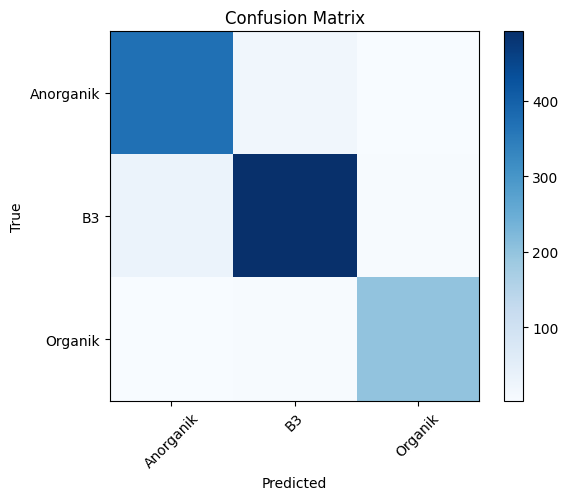

In [10]:
# --- EVALUATION ---
y_true = np.concatenate([y.numpy() for x,y in test_ds])
y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(np.concatenate([model.predict(x) for x,y in test_ds]), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks(range(NUM_CLASSES), class_names, rotation=45)
plt.yticks(range(NUM_CLASSES), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

model.save("trash_classifier.keras")

In [11]:
from sklearn.metrics import classification_report
import numpy as np

# label harus sama seperti training
label_names = ["Anorganik", "B3", "Organik"]

# --- GET TRUE LABELS ---
y_true = []
y_pred = []

for images, labels in val_ds:   # kalau mau test → ganti test_ds
    preds = model.predict(images)
    
    # prediksi index kelas
    y_pred.extend(np.argmax(preds, axis=1))
    
    # label sebenarnya
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# --- CLASSIFICATION REPORT ---
print(classification_report(y_true, y_pred, target_names=label_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 